# Voorspellen van de PV productie - % van geïnstalleerd vermogen

In [1]:
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scripts import weather_data_preprocess as wdp
from tensorflow.keras.models import Sequential, load_model, save_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout

## Data-analyse en samenstellen van dataset

! SKIP DIT HOOFDSTUK ALS JE NIET BESCHIKT OVER DE RUWE DATA !

In [2]:
# Ruwe weersdata info
weather_train_data_ingelmunster = [
    'Ingelmunster 2024-01-01 to 2024-01-31.csv',
    'Ingelmunster 2024-02-01 to 2024-02-29.csv',
    'Ingelmunster 2024-03-01 to 2024-03-31.csv',
    'Ingelmunster 2024-04-01 to 2024-04-30.csv',
    'Ingelmunster 2024-05-01 to 2024-05-31.csv',
    'Ingelmunster 2024-06-01 to 2024-06-30.csv',
    'Ingelmunster 2024-07-01 to 2024-07-31.csv',
    'Ingelmunster 2024-08-01 to 2024-08-31.csv',
    'Ingelmunster 2024-09-01 to 2024-09-30.csv',
    'Ingelmunster 2024-10-01 to 2024-10-31.csv',
    'Ingelmunster 2024-11-01 to 2024-11-30.csv',
    'Ingelmunster 2024-12-01 to 2024-12-31.csv',
    'Ingelmunster 2025-01-01 to 2025-01-31.csv',
    'Ingelmunster 2025-02-01 to 2025-02-29.csv',
    'Ingelmunster 2025-03-01 to 2025-03-31.csv',
]
weather_train_data_gullegem = [
    'Gullegem 2024-01-01 to 2024-01-31.csv',
    'Gullegem 2024-02-01 to 2024-02-29.csv',
    'Gullegem 2024-03-01 to 2024-03-31.csv',
    'Gullegem 2024-04-01 to 2024-04-30.csv',
    'Gullegem 2024-05-01 to 2024-05-31.csv',
    'Gullegem 2024-06-01 to 2024-06-30.csv',
    'Gullegem 2024-07-01 to 2024-07-31.csv',
    'Gullegem 2024-08-01 to 2024-08-31.csv',
    'Gullegem 2024-09-01 to 2024-09-30.csv',
    'Gullegem 2024-10-01 to 2024-10-31.csv',
    'Gullegem 2024-11-01 to 2024-11-30.csv',
    'Gullegem 2024-12-01 to 2024-12-31.csv',
    'Gullegem 2025-01-01 to 2025-01-31.csv',
]
weather_test_data_ingelmunster = [
    'Ingelmunster 2025-04-01 to 2025-04-30.csv',
]
ingelmunster_location = [50.920699369528734, 3.2532075343447575]
gullegem_location = [50.8447689, 3.1989718]

In [3]:
# importeren van de ruwe weersdata en deze preprocessen
processor = wdp.WeatherDataPreprocess()
df_weather_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_gullegem = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_test_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_test_gullegem = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
for file in range(len(weather_train_data_ingelmunster)):
    print(f'Processing {weather_train_data_ingelmunster[file]}')
    df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_train_data_ingelmunster[file])])
for file in range(len(weather_test_data_ingelmunster)):
    print(f'Processing {weather_test_data_ingelmunster[file]}')
    df_weather_test_ingelmunster = pd.concat([df_weather_test_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_test_data_ingelmunster[file])])
for file in range(len(weather_train_data_gullegem)):
    print(f'Processing {weather_train_data_gullegem[file]}')
    df_weather_gullegem = pd.concat([df_weather_gullegem, processor.preprocessWeatherData(lat=gullegem_location[0], lng=gullegem_location[1], file_name=weather_train_data_gullegem[file])])
df_weather_ingelmunster.head(10)

Processing Ingelmunster 2024-01-01 to 2024-01-31.csv
Processing Ingelmunster 2024-02-01 to 2024-02-29.csv
Processing Ingelmunster 2024-03-01 to 2024-03-31.csv
Processing Ingelmunster 2024-04-01 to 2024-04-30.csv
Processing Ingelmunster 2024-05-01 to 2024-05-31.csv


/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_80687/2868847632.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_train_data_ingelmunster[file])])


Processing Ingelmunster 2024-06-01 to 2024-06-30.csv
Processing Ingelmunster 2024-07-01 to 2024-07-31.csv
Processing Ingelmunster 2024-08-01 to 2024-08-31.csv
Processing Ingelmunster 2024-09-01 to 2024-09-30.csv
Processing Ingelmunster 2024-10-01 to 2024-10-31.csv
Processing Ingelmunster 2024-11-01 to 2024-11-30.csv
Processing Ingelmunster 2024-12-01 to 2024-12-31.csv
Processing Ingelmunster 2025-01-01 to 2025-01-31.csv
Processing Ingelmunster 2025-02-01 to 2025-02-29.csv
File not found at data/raw/Ingelmunster 2025-02-01 to 2025-02-29.csv. Please check the path and try again.
Processing Ingelmunster 2025-03-01 to 2025-03-31.csv
Processing Ingelmunster 2025-04-01 to 2025-04-30.csv
Processing Gullegem 2024-01-01 to 2024-01-31.csv
Processing Gullegem 2024-02-01 to 2024-02-29.csv
Processing Gullegem 2024-03-01 to 2024-03-31.csv
Processing Gullegem 2024-04-01 to 2024-04-30.csv


/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_80687/2868847632.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_test_ingelmunster = pd.concat([df_weather_test_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_test_data_ingelmunster[file])])
/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_80687/2868847632.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_gullegem = pd.con

Processing Gullegem 2024-05-01 to 2024-05-31.csv
Processing Gullegem 2024-06-01 to 2024-06-30.csv
Processing Gullegem 2024-07-01 to 2024-07-31.csv
Processing Gullegem 2024-08-01 to 2024-08-31.csv
Processing Gullegem 2024-09-01 to 2024-09-30.csv
Processing Gullegem 2024-10-01 to 2024-10-31.csv
Processing Gullegem 2024-11-01 to 2024-11-30.csv
Processing Gullegem 2024-12-01 to 2024-12-31.csv
Processing Gullegem 2025-01-01 to 2025-01-31.csv


,datetime,temp,humidity,cloudcover,solarenergy,uvindex,latitude,longitude,solar_azimuth,solar_elevation
0,2024-01-01 00:00:00,7.200,89.080,96.300,0.0,0.0,50.920699,3.253208,-3.058781,-1.083954
1,2024-01-01 00:15:00,7.125,89.600,96.600,0.0,0.0,50.920699,3.253208,-2.931440,-1.077916
2,2024-01-01 00:30:00,7.050,90.120,96.900,0.0,0.0,50.920699,3.253208,-2.807635,-1.066812
3,2024-01-01 00:45:00,6.975,90.640,97.200,0.0,0.0,50.920699,3.253208,-2.689024,-1.050984
4,2024-01-01 01:00:00,6.900,91.160,97.500,0.0,0.0,50.920699,3.253208,-2.576724,-1.030873
5,2024-01-01 01:15:00,7.000,91.195,95.725,0.0,0.0,50.920699,3.253208,-2.471311,-1.006968
6,2024-01-01 01:30:00,7.100,91.230,93.950,0.0,0.0,50.920699,3.253208,-2.372902,-0.979768
7,2024-01-01 01:45:00,7.200,91.265,92.175,0.0,0.0,50.920699,3.253208,-2.281271,-0.949750
8,2024-01-01 02:00:00,7.300,91.300,90.400,0.0,0.0,50.920699,3.253208,-2.195979,-0.917351
9,2024-01-01 02:15:00,7.325,90.540,90.800,0.0,0.0,50.920699,3.253208,-2.116463,-0.882961


In [4]:
# Een checkpoint toevoegen voor de ruwe weersdata
df_weather_ingelmunster.to_csv('data/processed/ingelmunster_weather_data.csv', index=False)
df_weather_gullegem.to_csv('data/processed/gullegem_weather_data.csv', index=False)

In [5]:
# Verwijderen van de kolommen die niet nodig zijn
df_weather_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_test_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_gullegem.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)

In [6]:
# Importeren van de ruwe productiedata en deze preprocessen
df_all_jvr = pd.read_csv('data/processed/pv_jvr_total.csv')
df_all_jvr['datetime'] = pd.to_datetime(df_all_jvr['datetime'])
df_all_ddp = pd.read_csv('data/processed/pv_ddp_total.csv')
df_all_ddp['datetime'] = pd.to_datetime(df_all_ddp['datetime'])
# Filter data voor een train en test set
df_production_jvr = df_all_jvr[df_all_jvr['datetime'].dt.year == 2024]
df_production_test_jvr = df_all_jvr[df_all_jvr['datetime'].dt.year == 2025]
df_production_ddp = df_all_ddp
df_production_jvr.tail(10)

,datetime,total_production_kwh,production_15_min_kwh,production_15_min_%
26943,2024-12-31 21:30:00,20591.94,0.0,0.0
26944,2024-12-31 21:45:00,20591.94,0.0,0.0
26945,2024-12-31 22:00:00,20591.94,0.0,0.0
26946,2024-12-31 22:15:00,20591.94,0.0,0.0
26947,2024-12-31 22:30:00,20591.94,0.0,0.0
26948,2024-12-31 22:45:00,20591.94,0.0,0.0
26949,2024-12-31 23:00:00,20591.94,0.0,0.0
26950,2024-12-31 23:15:00,20591.94,0.0,0.0
26951,2024-12-31 23:30:00,20591.94,0.0,0.0
26952,2024-12-31 23:45:00,20591.94,0.0,0.0


In [7]:
# Voeg de twee dataframes samen
df_jvr = pd.merge(df_production_jvr, df_weather_ingelmunster, on='datetime')
df_jvr.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_ddp = pd.merge(df_production_ddp, df_weather_gullegem, on='datetime')
df_ddp.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_test_jvr = pd.merge(df_production_test_jvr, df_weather_test_ingelmunster, on='datetime')
df_test_jvr.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_jvr.head(10)

,datetime,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
0,2024-03-14 08:15:00,0.092,8.325,54.475,0.325,0.5,-1.054120,0.330412
1,2024-03-14 08:45:00,0.387,9.175,46.225,0.575,1.5,-0.935324,0.399732
2,2024-03-14 09:00:00,0.231,9.600,42.100,0.700,2.0,-0.873267,0.432229
3,2024-03-14 09:15:00,0.203,10.000,48.875,0.900,2.5,-0.809274,0.463056
4,2024-03-14 09:30:00,0.172,10.400,55.650,1.100,3.0,-0.743247,0.492032
5,2024-03-14 09:45:00,0.085,10.800,62.425,1.300,3.5,-0.675122,0.518972
6,2024-03-14 12:00:00,4.431,14.800,52.400,2.000,6.0,0.018610,0.640320
7,2024-03-14 12:15:00,0.826,14.925,50.300,1.850,5.5,0.100055,0.637944
8,2024-03-14 12:30:00,0.747,15.050,48.200,1.700,5.0,0.181001,0.632235
9,2024-03-14 12:45:00,0.404,15.175,46.100,1.550,4.5,0.261057,0.623258


In [8]:
# Testdataframe controleren
# Print de eerste en laatste datetime
print("Eerste datetime:", df_test_jvr['datetime'].min())
print("Laatste datetime:", df_test_jvr['datetime'].max())

Eerste datetime: 2025-04-01 00:00:00
Laatste datetime: 2025-04-18 10:45:00


In [9]:
# Elia data importeren en preprocessen
# Bron: https://opendata.elia.be/
df_elia = pd.read_csv('data/raw/elia_pv_pred 2025-04-01 to 2025-04-18.csv', sep=';')
df_elia['datetime'] = pd.to_datetime(df_elia['Datetime']).dt.tz_localize(None)
df_elia['Predicted_%'] = (df_elia['Most recent forecast'] / df_elia['Monitored capacity'])
df_elia_processed = df_elia[['datetime', 'Predicted_%']].copy()
df_elia_processed.tail(100)

,datetime,Predicted_%
1628,2025-04-02 00:45:00,0.0
1629,2025-04-02 00:30:00,0.0
1630,2025-04-02 00:15:00,0.0
1631,2025-04-02 00:00:00,0.0
1632,2025-04-01 23:45:00,0.0
...,...,...
1723,2025-04-01 01:00:00,0.0
1724,2025-04-01 00:45:00,0.0
1725,2025-04-01 00:30:00,0.0
1726,2025-04-01 00:15:00,0.0


In [10]:
# Max productiepercentage in de Elia data vinden
max_production_percentage = df_elia_processed['Predicted_%'].max()
print("Max productiepercentage in Elia data:", max_production_percentage)

Max productiepercentage in Elia data: 0.6676576389439376


In [11]:
# Elia data van West-Vlaanderen toevoegen aan het test dataframe JVR
df_test_jvr = pd.merge(df_test_jvr, df_elia_processed, on='datetime', how='left')
df_test_jvr.info()
df_test_jvr.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             1676 non-null   datetime64[ns]
 1   production_15_min_%  1676 non-null   float64       
 2   temp                 1676 non-null   float64       
 3   cloudcover           1676 non-null   float64       
 4   solarenergy          1676 non-null   float64       
 5   uvindex              1676 non-null   float64       
 6   solar_azimuth        1676 non-null   float64       
 7   solar_elevation      1676 non-null   float64       
 8   Predicted_%          1676 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 118.0 KB


,datetime,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,Predicted_%
0,2025-04-01 00:00:00,0.0,5.700,10.0,0.0,0.0,-3.096242,-0.604923,0.0
1,2025-04-01 00:15:00,0.0,5.575,10.0,0.0,0.0,-3.017099,-0.601352,0.0
2,2025-04-01 00:30:00,0.0,5.450,10.0,0.0,0.0,-2.938549,-0.594553,0.0
3,2025-04-01 00:45:00,0.0,5.325,10.0,0.0,0.0,-2.860933,-0.584599,0.0
4,2025-04-01 01:00:00,0.0,5.200,10.0,0.0,0.0,-2.784555,-0.571593,0.0
5,2025-04-01 01:15:00,0.0,5.075,10.0,0.0,0.0,-2.709670,-0.555663,0.0
6,2025-04-01 01:30:00,0.0,4.950,10.0,0.0,0.0,-2.636479,-0.536959,0.0
7,2025-04-01 01:45:00,0.0,4.825,10.0,0.0,0.0,-2.565126,-0.515646,0.0
8,2025-04-01 02:00:00,0.0,4.700,10.0,0.0,0.0,-2.495700,-0.491899,0.0
9,2025-04-01 02:15:00,0.0,4.575,10.0,0.0,0.0,-2.428240,-0.465897,0.0


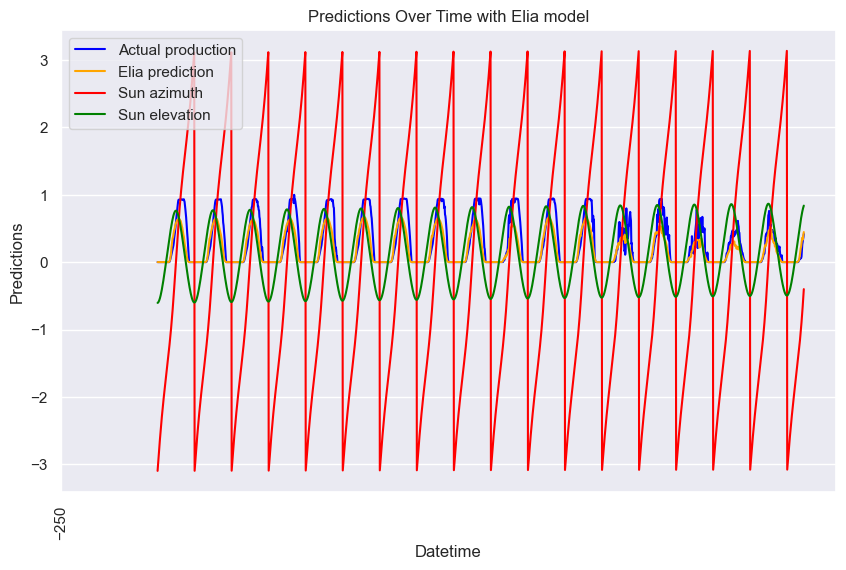

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df_test_jvr['production_15_min_%'], label='Actual production', color='blue')
plt.plot(df_test_jvr['Predicted_%'], label='Elia prediction', color='orange')
plt.plot(df_test_jvr['solar_azimuth'], label='Sun azimuth', color='red')
plt.plot(df_test_jvr['solar_elevation'], label='Sun elevation', color='green')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with Elia model')
plt.grid(True) 
x_ticks = plt.gca().get_xticks() 
x_ticks_selected = x_ticks[::24] 
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

In [13]:
# De trainingsdata van beide huizen samenvoegen
df_all = pd.concat([df_jvr, df_ddp], axis=0)

In [14]:
# Geef de dag van het jaar weer als een sinus- en cosinusgolf
# Dag van het jaar extraheren
df_all['day_of_year'] = df_all['datetime'].dt.dayofyear
df_test_jvr['day_of_year'] = df_test_jvr['datetime'].dt.dayofyear
# Bereken sinus- en cosinuswaarden voor day_of_year
df_all['day_of_year_sine'] = np.sin(2 * np.pi * df_all['day_of_year'] / 365)
df_all['day_of_year_cosine'] = np.cos(2 * np.pi * df_all['day_of_year'] / 365)
df_test_jvr['day_of_year_sine'] = np.sin(2 * np.pi * df_test_jvr['day_of_year'] / 365)
df_test_jvr['day_of_year_cosine'] = np.cos(2 * np.pi * df_test_jvr['day_of_year'] / 365)

In [15]:
# Verwijder onnodige kolommen
df_all.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_test_jvr.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_all.head()

,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
0,0.092,8.325,54.475,0.325,0.5,-1.054120,0.330412,0.956235,0.2926
1,0.387,9.175,46.225,0.575,1.5,-0.935324,0.399732,0.956235,0.2926
2,0.231,9.600,42.100,0.700,2.0,-0.873267,0.432229,0.956235,0.2926
3,0.203,10.000,48.875,0.900,2.5,-0.809274,0.463056,0.956235,0.2926
4,0.172,10.400,55.650,1.100,3.0,-0.743247,0.492032,0.956235,0.2926


In [16]:
# Vervang alle negatieve energiewaarden (%) met 0
df_all['production_15_min_%'] = df_all['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_test_jvr['production_15_min_%'] = df_test_jvr['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_all.describe()

,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
count,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000
mean,0.447936,12.790727,75.897132,0.413575,1.134916,-0.000259,0.045515,-0.116100,-0.132720
std,74.658457,5.987359,26.343544,0.674104,1.889317,1.801071,0.534972,0.686214,0.705715
min,0.000000,-2.700000,0.000000,0.000000,0.000000,-3.141515,-1.092474,-0.999991,-0.999963
25%,0.000000,8.475000,61.500000,0.000000,0.000000,-1.605858,-0.334096,-0.763889,-0.798779
50%,0.000000,12.900000,87.650000,0.025000,0.000000,-0.004936,0.038408,-0.230306,-0.284359
75%,0.171000,16.925000,96.700000,0.600000,1.750000,1.604758,0.447052,0.501242,0.556017
max,17793.070000,33.900000,100.000000,3.900000,10.000000,3.141587,1.092256,0.999991,1.000000


In [17]:
# maak het percentage energie een een waarde tussen 0 en 100%
df_all['production_15_min_%'] = df_all['production_15_min_%'] * 100
df_test_jvr['production_15_min_%'] = df_test_jvr['production_15_min_%'] * 100

In [18]:
# Estetic action move target column to the end
df_all = pd.concat([df_all.drop('production_15_min_%', axis=1), df_all['production_15_min_%']], axis=1)
df_all.head()

,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine,production_15_min_%
0,8.325,54.475,0.325,0.5,-1.054120,0.330412,0.956235,0.2926,9.2
1,9.175,46.225,0.575,1.5,-0.935324,0.399732,0.956235,0.2926,38.7
2,9.600,42.100,0.700,2.0,-0.873267,0.432229,0.956235,0.2926,23.1
3,10.000,48.875,0.900,2.5,-0.809274,0.463056,0.956235,0.2926,20.3
4,10.400,55.650,1.100,3.0,-0.743247,0.492032,0.956235,0.2926,17.2


In [19]:
df_all.describe()

,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine,production_15_min_%
count,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000,56804.000000,5.680400e+04
mean,12.790727,75.897132,0.413575,1.134916,-0.000259,0.045515,-0.116100,-0.132720,4.479362e+01
std,5.987359,26.343544,0.674104,1.889317,1.801071,0.534972,0.686214,0.705715,7.465846e+03
min,-2.700000,0.000000,0.000000,0.000000,-3.141515,-1.092474,-0.999991,-0.999963,0.000000e+00
25%,8.475000,61.500000,0.000000,0.000000,-1.605858,-0.334096,-0.763889,-0.798779,0.000000e+00
50%,12.900000,87.650000,0.025000,0.000000,-0.004936,0.038408,-0.230306,-0.284359,0.000000e+00
75%,16.925000,96.700000,0.600000,1.750000,1.604758,0.447052,0.501242,0.556017,1.710000e+01
max,33.900000,100.000000,3.900000,10.000000,3.141587,1.092256,0.999991,1.000000,1.779307e+06


In [20]:
# Alle waarden boven de 100(%) zijn uitschieters (dit zijn waarschijnlijk fouten als gevolg van ontbrekende gegevens). Deze worden verwijderd.
df_all = df_all[df_all['production_15_min_%'] <= 100]
df_all.describe()

,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine,production_15_min_%
count,56793.000000,56793.000000,56793.000000,56793.000000,56793.000000,56793.000000,56793.000000,56793.000000,56793.000000
mean,12.790705,75.896439,0.413606,1.134995,-0.000049,0.045534,-0.116230,-0.132721,12.801358
std,5.987829,26.344448,0.674118,1.889341,1.801039,0.534999,0.686136,0.705769,21.671118
min,-2.700000,0.000000,0.000000,0.000000,-3.141515,-1.092474,-0.999991,-0.999963,0.000000
25%,8.475000,61.500000,0.000000,0.000000,-1.605373,-0.334085,-0.763889,-0.798779,0.000000
50%,12.900000,87.650000,0.025000,0.000000,-0.004875,0.038461,-0.230306,-0.284359,0.000000
75%,16.925000,96.700000,0.600000,1.750000,1.604833,0.447072,0.501242,0.556017,17.025641
max,33.900000,100.000000,3.900000,10.000000,3.141587,1.092256,0.999991,1.000000,94.900000


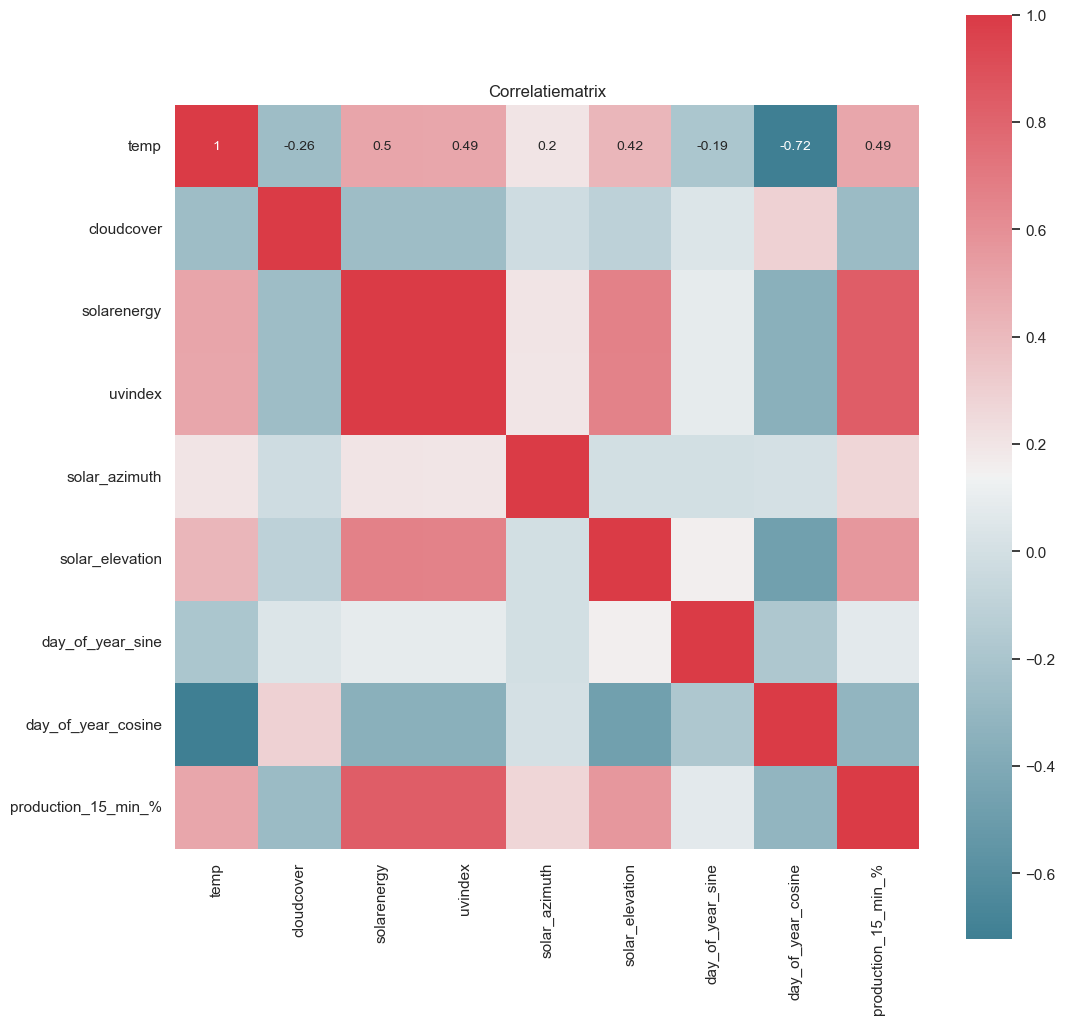

In [21]:
# Lineaire correlatie tussen de features - heatmap
# Visualiseer de onderlinge correlatiecoëfficiënten
f, ax = plt.subplots(figsize=(12, 12))
corr = df_all.corr()
sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    ax=ax,
    annot=True,
    annot_kws={"size": 10}
)
plt.title("Correlatiematrix")
plt.show()

In [22]:
# Bewaren van train en test dataframes als parquet files
df_all.to_parquet('datasets/pv_train_data.parquet', index=False)
df_test_jvr.to_parquet('datasets/pv_test_data.parquet', index=False)

## Inladen van Parquet data

Als je niet beschikt over data of de CSV bestanden met weers- en productie data kan je deze voorbewerkte Parquet bestanden inladen en gebruiken.

In [23]:
df = pd.read_parquet('datasets/pv_train_data.parquet')
df_test = pd.read_parquet('datasets/pv_test_data.parquet')

## Pre-processing van de data

In [24]:
# Splits de dataset in een trainings- en testset
y = df['production_15_min_%']
X = df.drop(['production_15_min_%'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# De gegevens schalen. Aangezien er geen outliers zijn, kunnen we de MinMaxScaler gebruiken
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logistic regression
polynomial = PolynomialFeatures(2)
polynomial.fit(X_train)
X_train = polynomial.transform(X_train)
X_test = polynomial.transform(X_test)

## Training

In [26]:
# Verschillende hyperparameters uitproberen voor de Random Forest Regressor
estimators = [10, 50, 100]#, 150, 200]
rf_depths = [10, 15, 20, 25]#, 30, 45, 50]

In [27]:
# Trainen van elke combinatie van hyperparameters en opslaan van het beste model
best_score = 0
best_model = None
for estimator in estimators:
    for depth in rf_depths:
        print(f"Training model with estimators: {estimator}, depth: {depth}")
        rf_model = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
        rf_model.fit(X_train, y_train)
        score = rf_model.score(X_test, y_test)
        print(f"Model score: {score}")
        if score > best_score:
            best_score = score
            best_model = rf_model
            # Save the model
            print(f"New best model found with estimators: {estimator}, depth: {depth}, and score: {score}")
            with open(f'models/pv_ML.pkl', 'wb') as file:
                pickle.dump(rf_model, file)

Training model with estimators: 10, depth: 10
Model score: 0.843231802857845
New best model found with estimators: 10, depth: 10, and score: 0.843231802857845
Training model with estimators: 10, depth: 15
Model score: 0.8477047332096097
New best model found with estimators: 10, depth: 15, and score: 0.8477047332096097
Training model with estimators: 10, depth: 20
Model score: 0.8464009342571028
Training model with estimators: 10, depth: 25
Model score: 0.844710962850403
Training model with estimators: 50, depth: 10
Model score: 0.8471060777224365
Training model with estimators: 50, depth: 15
Model score: 0.8559493713942403
New best model found with estimators: 50, depth: 15, and score: 0.8559493713942403
Training model with estimators: 50, depth: 20
Model score: 0.8553369354847232
Training model with estimators: 50, depth: 25
Model score: 0.8575557030842013
New best model found with estimators: 50, depth: 25, and score: 0.8575557030842013
Training model with estimators: 100, depth: 10


## Testen op ongeziene data

In [28]:
df_test.head()

,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,Predicted_%,day_of_year_sine,day_of_year_cosine
0,0.0,5.700,10.0,0.0,0.0,-3.096242,-0.604923,0.0,0.999991,0.004304
1,0.0,5.575,10.0,0.0,0.0,-3.017099,-0.601352,0.0,0.999991,0.004304
2,0.0,5.450,10.0,0.0,0.0,-2.938549,-0.594553,0.0,0.999991,0.004304
3,0.0,5.325,10.0,0.0,0.0,-2.860933,-0.584599,0.0,0.999991,0.004304
4,0.0,5.200,10.0,0.0,0.0,-2.784555,-0.571593,0.0,0.999991,0.004304


In [29]:
# Splits de dataset in een trainings- en testset
actual = df_test[['production_15_min_%']]
elia = df_test[['Predicted_%']]
input = df_test.drop(['production_15_min_%', 'Predicted_%'], axis=1)
input.head()

,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
0,5.700,10.0,0.0,0.0,-3.096242,-0.604923,0.999991,0.004304
1,5.575,10.0,0.0,0.0,-3.017099,-0.601352,0.999991,0.004304
2,5.450,10.0,0.0,0.0,-2.938549,-0.594553,0.999991,0.004304
3,5.325,10.0,0.0,0.0,-2.860933,-0.584599,0.999991,0.004304
4,5.200,10.0,0.0,0.0,-2.784555,-0.571593,0.999991,0.004304


In [30]:
# Inladen van het beste ML model
with open('models/pv_ML.pkl', 'rb') as file:
    best_ml_model = pickle.load(file)

In [31]:
# Voeg de daadwerkelijke waarden toe aan de df_result dataframe
df_result = actual[['production_15_min_%']]
print(df_result)

      production_15_min_%
0                     0.0
1                     0.0
2                     0.0
3                     0.0
4                     0.0
...                   ...
1671                 26.0
1672                 29.5
1673                 33.4
1674                 37.2
1675                 41.8

[1676 rows x 1 columns]


In [32]:
# Maak een voorspelling voor elke regel in de testdataset en voeg deze toe aan de df_result dataframe
input = scaler.transform(input)
input = polynomial.transform(input)
df_result['predicted_with_ML(%)'] = best_ml_model.predict(input)
df_result.head()

,production_15_min_%,predicted_with_ML(%)
0,0.0,0.000007
1,0.0,0.000007
2,0.0,0.000007
3,0.0,0.000007
4,0.0,0.000007


In [33]:
# Elia data toevoegen aan de df_result dataframe
df_result['predicted_with_Elia(%)'] = elia['Predicted_%'].values
df_result.head(1000)

,production_15_min_%,predicted_with_ML(%),predicted_with_Elia(%)
0,0.0,0.000007,0.000000
1,0.0,0.000007,0.000000
2,0.0,0.000007,0.000000
3,0.0,0.000007,0.000000
4,0.0,0.000007,0.000000
...,...,...,...
995,11.6,8.678181,0.159011
996,16.1,10.310205,0.213381
997,18.1,12.653155,0.259714
998,20.8,14.678646,0.305767


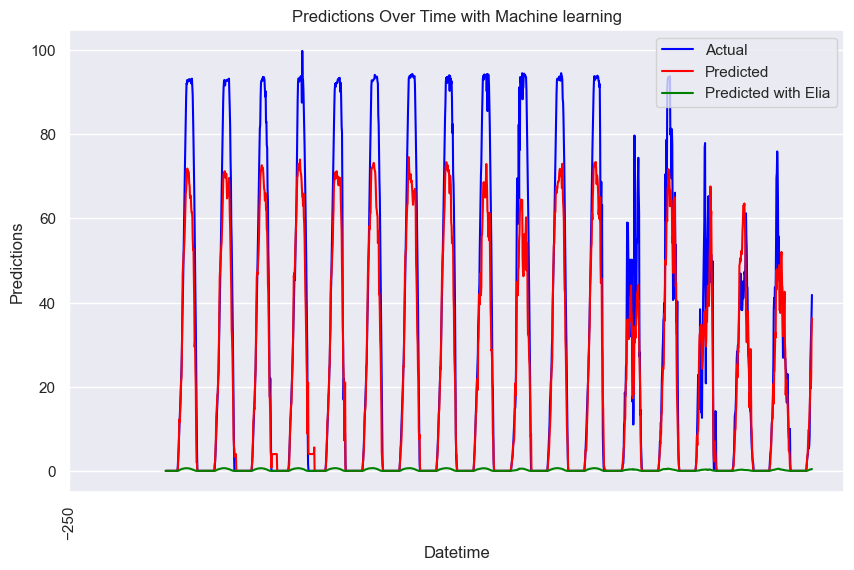

In [34]:
# Zet de voorspellingen uit in een grafiek
plt.figure(figsize=(10, 6))
plt.plot(df_result['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result['predicted_with_ML(%)'], label='Predicted', color='red')
plt.plot(df_result['predicted_with_Elia(%)'], label='Predicted with Elia', color='green')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with Machine learning')
plt.grid(True) 
x_ticks = plt.gca().get_xticks() 
x_ticks_selected = x_ticks[::24] 
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

In [35]:
# Zet de voorspellingen uit van 1 dag
df_result_day = df_result[df_result.index.date == pd.to_datetime('2025-04-01').date()]
plt.figure(figsize=(10, 6))
plt.plot(df_result_day['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_day['predicted_with_ML(%)'], label='Predicted', color='red')
plt.plot(df_result_day['predicted_with_Elia(%)'], label='Predicted with Elia', color='green')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with Machine learning')
plt.grid(True) 
x_ticks = plt.gca().get_xticks() 
x_ticks_selected = x_ticks[::24] 
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

AttributeError: 'RangeIndex' object has no attribute 'date'

In [ ]:
# Calculating the accuracy of the ML model based on the test data
print("### ML-model ###")
print(f"mae: {mean_absolute_error(df_result['production_15_min_%'], df_result['predicted_with_ML(%)'])}")
print(f"mse: {mean_squared_error(df_result['production_15_min_%'], df_result['predicted_with_ML(%)'])}")
print(f"r2: {r2_score(df_result['production_15_min_%'], df_result['predicted_with_ML(%)'])}")

### ML-model ###
mae: 1.9382514576810257
mse: 26.196197993354694
r2: 0.7703365852409297


In [ ]:
# Calculating the accuracy of the Elia model based on the test data
print("### Elia-model ###")
print(f"mae: {mean_absolute_error(df_result['production_15_min_%'], df_result['predicted_with_Elia(%)'])}")
print(f"mse: {mean_squared_error(df_result['production_15_min_%'], df_result['predicted_with_Elia(%)'])}")
print(f"r2: {r2_score(df_result['production_15_min_%'], df_result['predicted_with_Elia(%)'])}")

### Elia-model ###
mae: 2.209280798615666
mse: 40.118034544932314
r2: 0.6482831283627966
